# **Assignment 2 - Loan Approval Prediction**
### **Andrei Sumin**

In this assignment, we will explore and develop a machine learning model to predict loan approvals.
Using a dataset with socio-demographic and financial data, our goal is to analyze and understand
the factors that influence loan approval and build a predictive model based on these insights.

---

#### 1. **Dataset Loading:** 
We begin by loading the dataset, which includes various features that may
impact loan approval outcomes.

In [ ]:
#general modules and libraries import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

#sklearn import
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics 
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

In [641]:
data = pd.read_csv('dataset.csv') # convert dataset into pandas dataframe

data.sample(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
328,LP002086,Female,Yes,0,Graduate,No,4333,2451.0,110.0,360.0,1.0,Urban,N
200,LP001674,Male,Yes,1,Not Graduate,No,2600,2500.0,90.0,360.0,1.0,Semiurban,Y
347,LP002131,Male,Yes,2,Not Graduate,No,3083,2168.0,126.0,360.0,1.0,Urban,Y
179,LP001630,Male,No,0,Not Graduate,No,2333,1451.0,102.0,480.0,0.0,Urban,N
234,LP001778,Male,Yes,1,Graduate,No,3155,1779.0,140.0,360.0,1.0,Semiurban,Y


#### 2. **Exploratory Data Analysis (EDA):** 
We analyze patterns and correlations within the data.

In [642]:
data.shape #get the shape of our data

(614, 13)

In [643]:
data.describe() #describe our data (get mean, std, etc.)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [644]:
data.info() #get information on data types, non-null values amount. We can also get a list of columns with this function.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


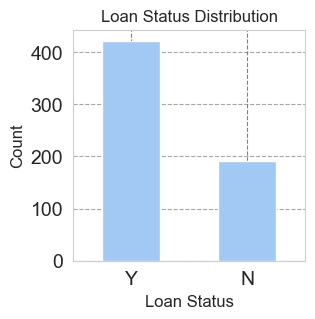

In [645]:
# Plot the distribution of the target variable
sns.set_palette('pastel')
plt.figure(figsize=(3,3))
data['Loan_Status'].value_counts().plot(kind='bar', title='Loan Status Distribution', fontsize = 14, rot = 0)
plt.xlabel('Loan Status', fontsize = 12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel('Count', fontsize = 12)
plt.show()

In [646]:
#Data imbalance calculation
print("Imbalance "+(str(round(data['Loan_Status'].value_counts()[0]/data['Loan_Status'].value_counts()[1],2)))+":1")

Imbalance 2.2:1


Considering we have a pretty large dataset, imbalance is mild. However caution with class_weigh is required.

In [647]:
#Check for duplicated values
check_for_duplicates = lambda data: print("No duplicates") if data.duplicated().sum() == 0 else print(data[data.duplicated()])
check_for_duplicates(data)

No duplicates


In [648]:
data.isnull().sum() # numner of null values in each column

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [649]:
# Let's create a marker for missing data in the row for better future interpretability 

data["Missing_Data"] = data.isnull().any(axis=1).astype(int)

We have a range of methods to deal with the missing data:
- Elimination - we lose a lot of data
- Inspection - should be performed manually - not an option due to high volume of manual work
- Identification - identification of missing data with regression/classificaiton models - a complex method
- Replacement - replacement of missing data with alternatives - may distort the the original dataset

In this case we will settle on **replacement** missing data with the *most frequant category* or *column mean*.

We should split data to **categorical** and **numerical** data first.

In [651]:
df_categorical=data.select_dtypes(include=['object']).iloc[:,1:].copy() # we do not include ID number
df_categorical.sample(5)

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
305,Male,No,0,Not Graduate,No,Urban,N
298,Female,No,0,Graduate,No,Rural,N
488,Male,Yes,2,Graduate,Yes,Semiurban,Y
156,Male,Yes,1,Graduate,No,Rural,Y
89,Male,Yes,0,Graduate,No,Semiurban,Y


In [652]:
from sklearn.impute import SimpleImputer
# substitution of Nas with most frequent categories
df_categorical = pd.DataFrame(SimpleImputer(strategy='most_frequent').fit_transform(df_categorical), columns = df_categorical.columns)

df_categorical.isna().any() #check for impution sucess

Gender           False
Married          False
Dependents       False
Education        False
Self_Employed    False
Property_Area    False
Loan_Status      False
dtype: bool

In [653]:
df_numerical=data.select_dtypes(include=[np.number]).drop(["Credit_History", "Missing_Data"], axis = 1).copy() 
# we do not include missing data marker, missing values for Credit_History should be also delt with separately, it is a categorical variable

df_numerical["target"] = (data["Loan_Status"] == "Y").astype(int)

df_numerical.sample(5)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,target
470,3450,2079.0,162.0,360.0,1
77,1000,3022.0,110.0,360.0,0
478,16667,2250.0,86.0,360.0,1
162,3089,1280.0,121.0,360.0,0
335,5503,4490.0,70.0,NaN,1


In [654]:
# substitution of Nas with columns means
df_numerical = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(df_numerical), columns = df_numerical.columns)

# add and manage Credit_History column
df_numerical["Credit_History"] = data["Credit_History"]
df_numerical["Credit_History"] = SimpleImputer(strategy='most_frequent').fit_transform(df_numerical["Credit_History"].values.reshape(-1, 1))



df_numerical.isna().any() # check for impution sucess

ApplicantIncome      False
CoapplicantIncome    False
LoanAmount           False
Loan_Amount_Term     False
target               False
Credit_History       False
dtype: bool

#### Categorical Data EDA

In [655]:
df_categorical

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,Urban,Y
1,Male,Yes,1,Graduate,No,Rural,N
2,Male,Yes,0,Graduate,Yes,Urban,Y
3,Male,Yes,0,Not Graduate,No,Urban,Y
4,Male,No,0,Graduate,No,Urban,Y
...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,Rural,Y
610,Male,Yes,3+,Graduate,No,Rural,Y
611,Male,Yes,1,Graduate,No,Urban,Y
612,Male,Yes,2,Graduate,No,Urban,Y


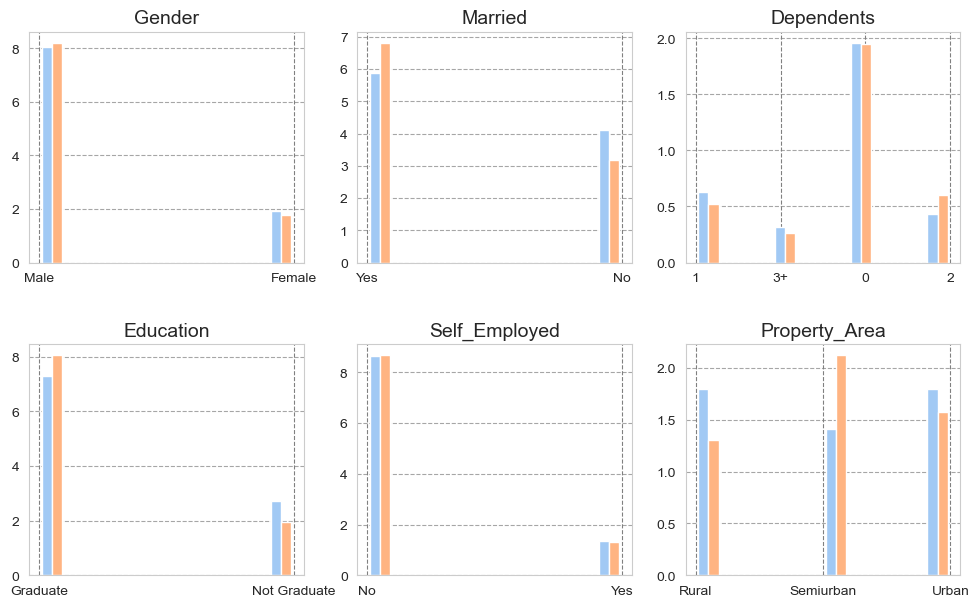

In [656]:
df_c_0=df_categorical[df_categorical["Loan_Status"] == "N"] # records wih Loan Status = N
df_c_1=df_categorical[df_categorical["Loan_Status"] == "Y"] # records wih Loan Status = Y


fig, axes = plt.subplots(2, 3,figsize=[10,6])
axes = axes.flatten()
fig.tight_layout(h_pad=4)

i=0
for x in df_categorical.columns[:-1]:
    plt.sca(axes[i]) # set the current Axes
    plt.hist([df_c_0[x],df_c_1[x]],density=True) # plot the histograms
    plt.title(x, fontsize = 14) # put titles to the graphs
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    i+=1
plt.show()

The distribution of `Gender` and `Self_Employed` across the target classes shows little variation, suggesting that these features might not have strong predictive power.

To proceed with algorithms we should represent categorical variables in numerical form.

In [657]:
selection_categorical=['Married', 'Dependents', 'Education', 'Property_Area'] # categories that we select to proceed with

# we do not include Loan_Status, it will be our target variable

dummies = pd.get_dummies(df_categorical[selection_categorical]) # creation of a dataframe of dummy variables identifying classes

print(dummies.shape)

dummies.sample(5)

(614, 11)


,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
47,0,1,1,0,0,0,1,0,0,0,1
32,1,0,0,1,0,0,1,0,1,0,0
66,1,0,1,0,0,0,0,1,0,0,1
305,1,0,1,0,0,0,0,1,0,0,1
127,1,0,1,0,0,0,1,0,1,0,0


#### Numerical Data EDA

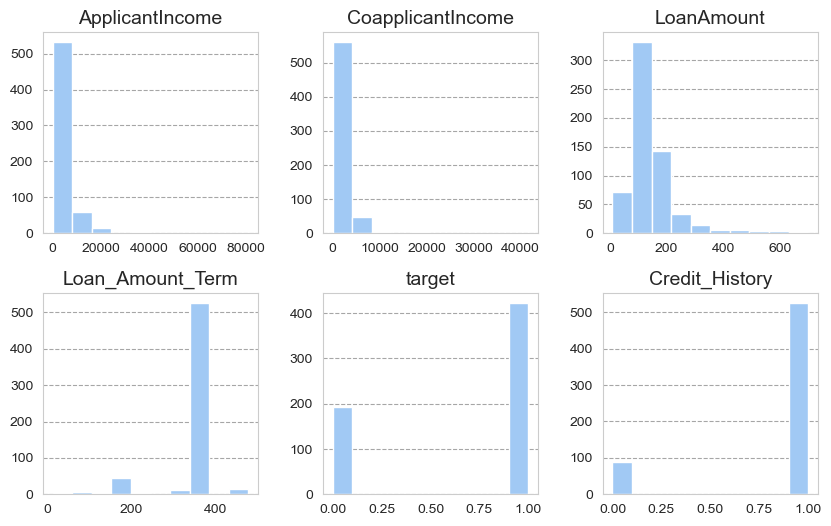

In [658]:
df_n_hist = df_numerical.hist(layout=(2,3), figsize=(10,6))

for ax in df_n_hist.flatten():  # Iterate over all axes
    ax.grid(axis='y', linestyle='--', color='gray', alpha=0.7)
    ax.grid(axis='x', visible=False)
    ax.set_title(ax.get_title(), fontsize=14)

`ApplicantIncome` and `CoapplicantIncome` require transformation

In [659]:
df_numerical['logApplicantIncome']=df_numerical['ApplicantIncome'].apply(lambda x: math.log(x+1))
df_numerical['logCoapplicantIncome']=df_numerical['CoapplicantIncome'].apply(lambda x: math.log(x+1))

df_numerical = df_numerical[[col for col in df_numerical if col != 'target'] + ['target']] # target column to the end

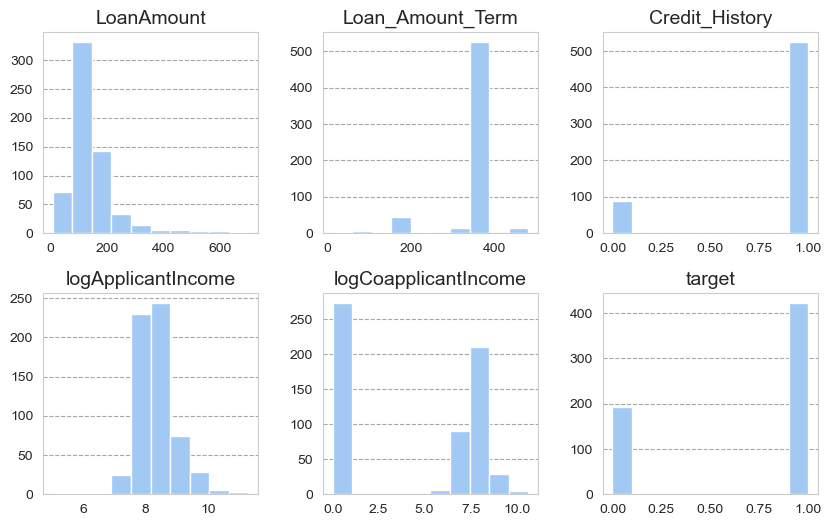

In [660]:
df_n_hist=df_numerical.drop(columns=['ApplicantIncome', 'CoapplicantIncome']).hist(layout=(2,3), figsize=(10,6))

for ax in df_n_hist.flatten():  # Iterate over all axes
    ax.grid(axis='y', linestyle='--', color='gray', alpha=0.7)
    ax.grid(axis='x', visible=False)
    ax.set_title(ax.get_title(), fontsize=14)

In [661]:
selection_numerical = df_numerical.drop(columns=['ApplicantIncome', 'CoapplicantIncome']).columns

# dataframe containing numerical data with substitution of some columns with transformed logorithmical values
df_selection_numerical=df_numerical[selection_numerical] 

print(df_selection_numerical.shape)

(614, 6)


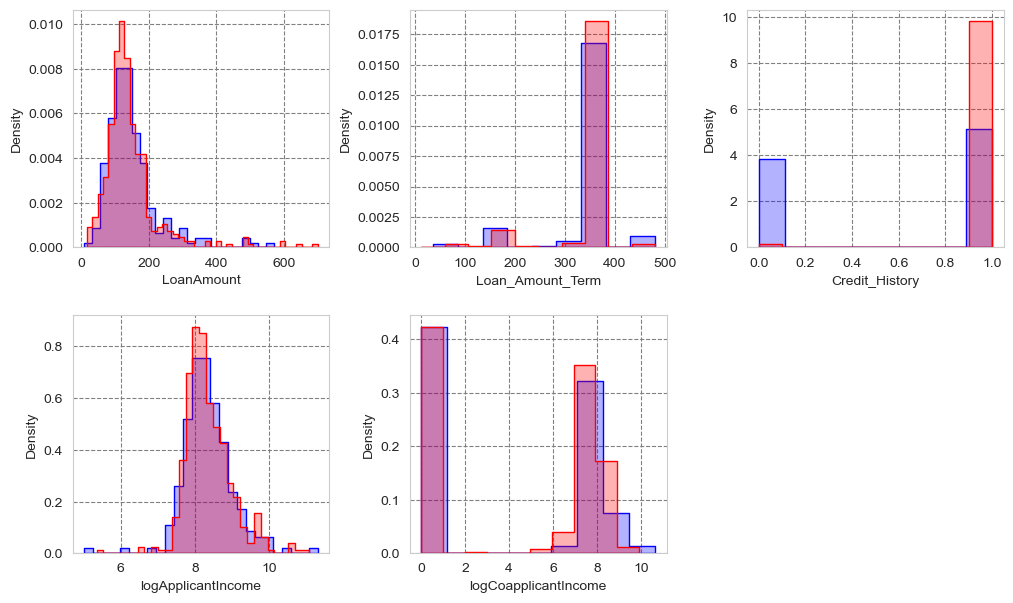

In [662]:
X0 = df_selection_numerical[df_selection_numerical['target']==0].drop("target", axis = 1)
X1 = df_selection_numerical[df_selection_numerical['target']==1].drop("target", axis = 1)

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10,6))
fig.tight_layout(h_pad=3, w_pad = 3)

for i, ax in enumerate(axes.flat):
    if i < df_selection_numerical.drop("target", axis=1).columns.size:
        sns.histplot(X0.iloc[:, i], color="blue", ax=ax, stat='density', element="step", alpha=0.3)
        sns.histplot(X1.iloc[:, i], color="red", ax=ax, stat='density', element="step", alpha=0.3)
    else:
        ax.axis('off')

Insights from the histograms:
- LoanAmount: There seems to be a moderate overlap between the two groups, indicating some separation power.
- Credit_History: A difference is visible, where one group dominates specific values. This suggests it could be a strong predictor.

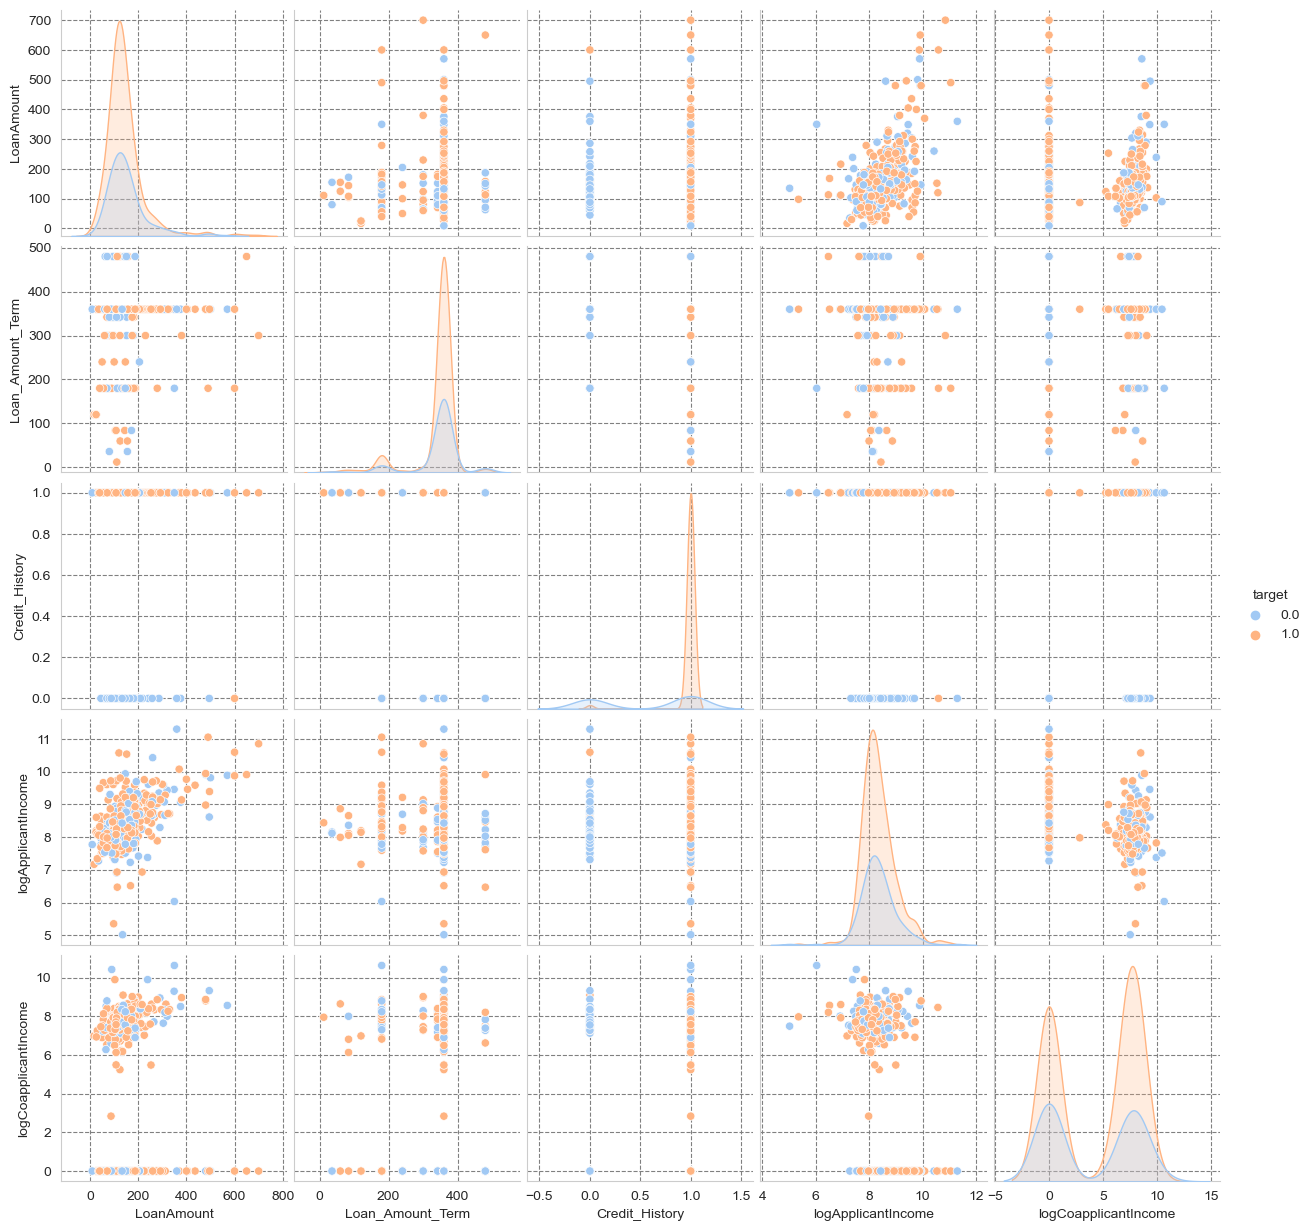

In [663]:
sns.pairplot(df_selection_numerical, hue='target')

Insights from the pairplot:
- LoanAmount_Term and logCoapplicantIncome: There appears to be some clustering of target values, but overlap is present.
- Credit_History: Its scatter points are well-separated for some variable combinations.

#### 3. **Data scaling:** 
We normalize the feature values using MinMax scaling to improve model performance.

<AxesSubplot:>

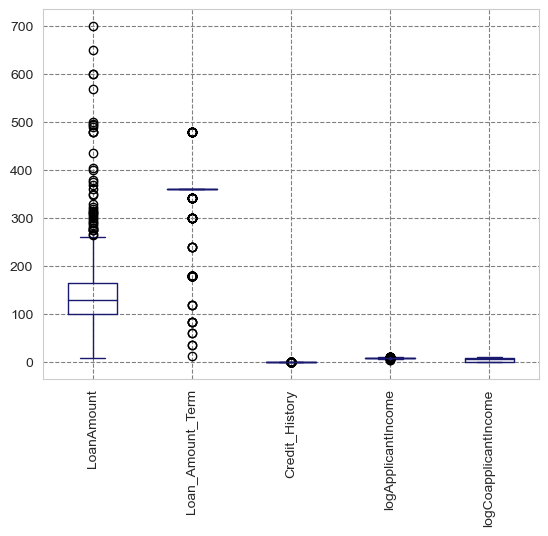

In [664]:
df_selection_numerical.drop("target", axis = 1).boxplot(rot = 90, color = "midnightblue")

Numerical data is on very different scales. Scaling is required.

<AxesSubplot:>

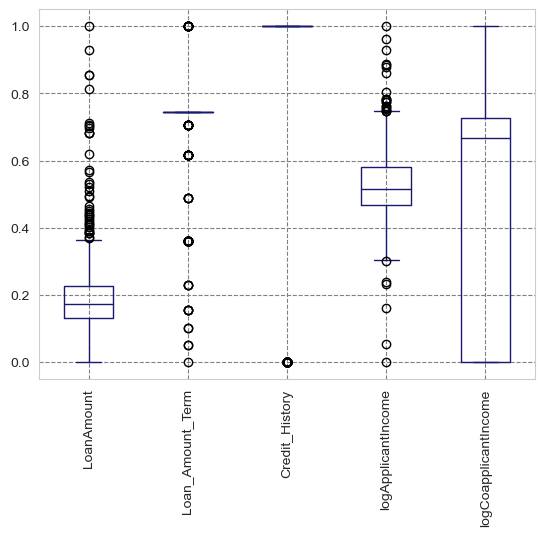

In [665]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(copy=False,feature_range=(0, 1)).fit(df_selection_numerical.drop("target", axis = 1)) # No target
scaled_df_numerical = pd.DataFrame(scaler.transform(df_selection_numerical.iloc[:,:-1]), columns = df_selection_numerical.drop("target", axis = 1).columns)


scaled_df_numerical.boxplot(rot = 90, color = 'midnightblue')

In [666]:
# set of variables
X=pd.concat([dummies,scaled_df_numerical], axis = 1)
print(X.shape)
X.sample(5)

(614, 16)


,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,LoanAmount,Loan_Amount_Term,Credit_History,logApplicantIncome,logCoapplicantIncome
585,0,1,0,1,0,0,1,0,1,0,0,0.235890,0.153846,1.0,0.532283,0.752687
83,0,1,1,0,0,0,1,0,0,1,0,0.370478,0.743590,1.0,0.585909,0.725653
501,1,0,1,0,0,0,1,0,0,1,0,0.131693,0.743590,1.0,0.483863,0.000000
481,0,1,0,0,0,1,0,1,1,0,0,0.150507,0.743590,1.0,0.480607,0.000000
472,0,1,0,0,0,1,1,0,0,1,0,0.131693,0.743590,1.0,0.546757,0.000000


In [667]:
# prediction variable
y = df_selection_numerical["target"]
print(y.shape)
y.sample(5)

(614,)


544    1.0
350    1.0
205    1.0
225    0.0
89     1.0
Name: target, dtype: float64

Our data is ready for training. It is scaled to [0;1] interval and has only 16 variables, PCA will not be very useful.

#### 4. **Data Splitting:** 
Split the dataset into training and testing subsets to evaluate model accuracy.

In [668]:
from sklearn.model_selection import train_test_split

#Splitting the data

X_train, X_test, y_train, y_test = train_test_split(
                                                    X, y, # data variables and target variable
                                                    test_size =0.30, # by default is 75%-25%
                                                    stratify=y, # preserve target propotions 
                                                    random_state= 123 # fix random seed for replicability

                                                    ) 

                                                    

#We can try and rebalance the training set so that we have more balanced trianing set

from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=123)
X_train, y_train = smote_enn.fit_resample(X_train, y_train)
                                                
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(295, 16) (185, 16)
(295,) (185,)


Data is rebalanced in such a way that training set and test set have roughly the same amount of samples for both classes.

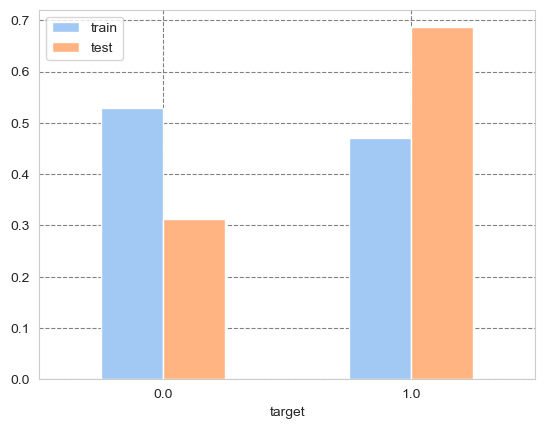

In [669]:
y_train_dist=y_train.groupby(y_train).size()/y_train.size
y_test_dist=y_test.groupby(y_test).size()/y_test.size

train_test_dist = pd.DataFrame({'train': y_train_dist, 'test': y_test_dist})
ax = train_test_dist.plot.bar(rot=0)

#### 5. **Model Training and Evaluation:** 
We train several machine learning models and measure the performance of each model using appropriate metrics.

**Let's creat functions for each model best parameters search and ROC curve calculation**

In [670]:
models = {}

# function applying the gridsearch for a certain model

def GridS(classifier, parameters):
    gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=0, n_jobs=-1)
    gs = gs.fit(X_train, y_train)
    print ("Best model | f1_train: ", gs.best_score_, " using: ", gs.best_params_)
   
    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)
    
    # Training FPR
    tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_pred_train).ravel()
    fpr_train = fp_train / (fp_train + tn_train)

    # Test FPR
    tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred).ravel()
    fpr_test = fp_test / (fp_test + tn_test)

    print("f1        | train %.3f  | test %.3f" % (f1_score(y_train, y_pred_train), f1_score(y_test, y_pred) )) 
    print("accuracy  | train %.3f  | test %.3f" % (accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred) )) 
    print("precision | train %.3f  | test %.3f" % (precision_score(y_train, y_pred_train), precision_score(y_test, y_pred) )) 
    print("recall    | train %.3f  | test %.3f" % (recall_score(y_train, y_pred_train), recall_score(y_test, y_pred) ))
    print("fpr       | train %.3f  | test %.3f" % (fpr_train, fpr_test ))
    con_mx = confusion_matrix(y_test, y_pred)
    print("")
    print(con_mx)
    plt.figure(figsize=(3,2))
    sns.heatmap(con_mx, annot=True, fmt='d', cmap="Blues")
    
    return best_model
    
    
#funiction creating a ROC curve for a model
    
def ROC_AUC(model,X_train,y_train,X_test,y_test):
    model.fit(X_train, y_train)

    y_probs = model.predict_proba(X_test) 

    fpr, tpr, thresholds1 =metrics.roc_curve(y_test,  y_probs[:,1])

    import matplotlib.pyplot as plt
    plt.figure(figsize=(3,3))
    plt.plot(fpr, tpr, label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    auc = metrics.roc_auc_score(y_test, y_probs[:,1])
    print('AUC: %.2f' % auc)
    return (fpr, tpr, auc, thresholds1)


#funiction packing models into a dictionary

def pack_model(modelname, model, fpr, tpr, auc, thr):
    models.update({
        modelname: {
            "model" : model,
            "fpr" : fpr,
            "tpr" : tpr,
            "auc" : auc,
            "thr" : thr
        }
    })

### KNN classifier

Best model | f1_train:  0.8158087526508578  using:  {'n_neighbors': 15}
f1        | train 0.850  | test 0.658
accuracy  | train 0.864  | test 0.589
precision | train 0.890  | test 0.768
recall    | train 0.813  | test 0.575
fpr       | train 0.090  | test 0.379

[[36 22]
 [54 73]]


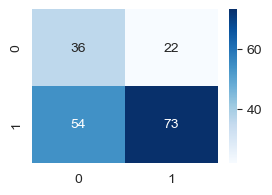

In [671]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier()
parameters = {'n_neighbors':np.arange(10,100,5)}

model_knn = GridS(classifier,parameters)

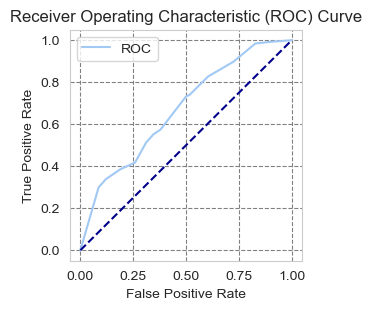

AUC: 0.67


In [672]:
fpr_knn, tpr_knn, auc_knn, thr_knn = ROC_AUC(model_knn,X_train,y_train,X_test,y_test)

pack_model("KNN", model_knn, fpr_knn, tpr_knn, auc_knn, thr_knn)

### Decision Tree classifier

Best model | f1_train:  0.9251887439945091  using:  {'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10}
f1        | train 0.963  | test 0.733
accuracy  | train 0.966  | test 0.649
precision | train 0.985  | test 0.767
recall    | train 0.942  | test 0.701
fpr       | train 0.013  | test 0.466

[[31 27]
 [38 89]]


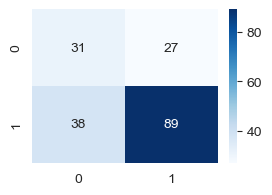

In [673]:
from sklearn.tree import DecisionTreeClassifier

#parameters are chosen to prevent overfitting
classifier = DecisionTreeClassifier(random_state = 123)
parameters = {
    'criterion': ['entropy','gini'], 
    'max_depth': [3,5,10],
    'min_samples_split': [10,20,30],
    'min_samples_leaf': [5,10,20],
    'class_weight' : [None, 'balanced']
}

model_dtree = GridS(classifier,parameters)

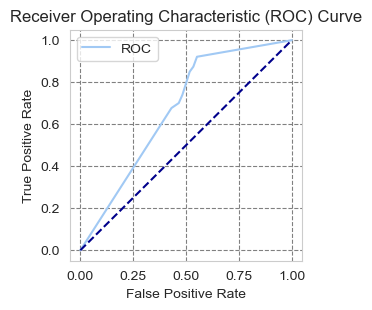

AUC: 0.67


In [674]:
fpr_dtree, tpr_dtree, auc_dtree, thr_dtree = ROC_AUC(model_dtree,X_train,y_train,X_test,y_test)

pack_model("Decision Tree", model_dtree, fpr_dtree, tpr_dtree, auc_dtree, thr_dtree)

Resulting ROC curve lack smoothness. It happens because of low tree depth.

|--- Credit_History <= 0.98
|   |--- class: 0.0
|--- Credit_History >  0.98
|   |--- Property_Area_Rural <= 0.50
|   |   |--- Married_Yes <= 0.50
|   |   |   |--- LoanAmount <= 0.14
|   |   |   |   |--- logApplicantIncome <= 0.45
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- logApplicantIncome >  0.45
|   |   |   |   |   |--- class: 0.0
|   |   |   |--- LoanAmount >  0.14
|   |   |   |   |--- logApplicantIncome <= 0.56
|   |   |   |   |   |--- logApplicantIncome <= 0.49
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- logApplicantIncome >  0.49
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- logApplicantIncome >  0.56
|   |   |   |   |   |--- class: 1.0
|   |   |--- Married_Yes >  0.50
|   |   |   |--- Loan_Amount_Term <= 0.61
|   |   |   |   |--- LoanAmount <= 0.16
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- LoanAmount >  0.16
|   |   |   |   |   |--- class: 1.0
|   |   |   |--- Loan_Amount_Term >  0.61
|   |   |   |   |--- class: 1

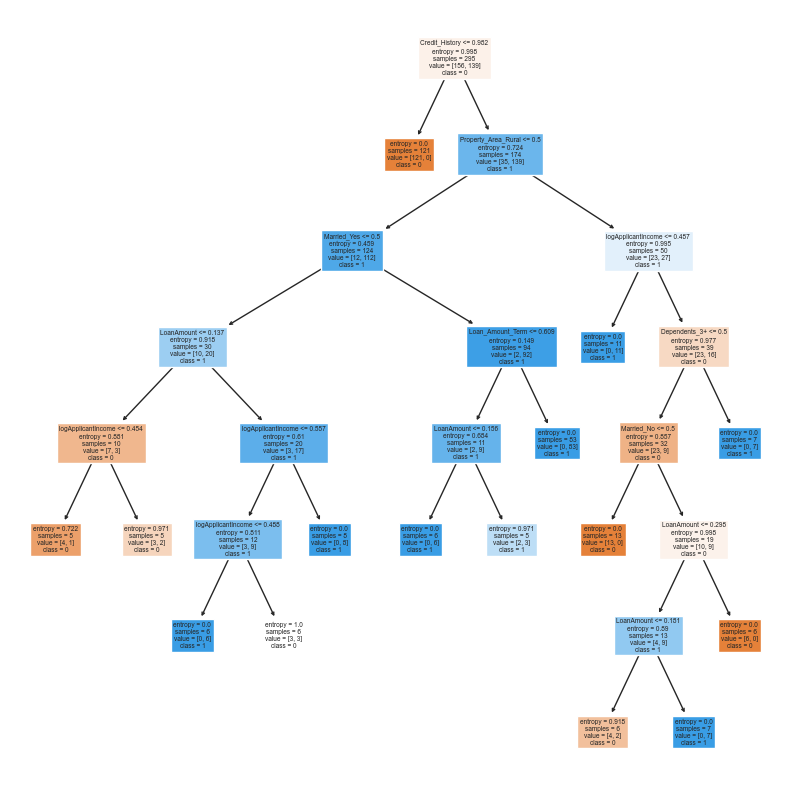

In [675]:
from sklearn import tree

r = tree.export_text(model_dtree,feature_names=X_test.columns.tolist())
print(r)

fig = plt.figure(figsize=(10,10))
_ = tree.plot_tree(model_dtree, 
                   feature_names=X_test.columns.tolist(),  
                   class_names=['0','1'],
                   filled=True)


### Random Forest classifier

Best model | f1_train:  0.9428070175438598  using:  {'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
f1        | train 0.975  | test 0.852
accuracy  | train 0.976  | test 0.778
precision | train 0.952  | test 0.787
recall    | train 1.000  | test 0.929
fpr       | train 0.045  | test 0.552

[[ 26  32]
 [  9 118]]


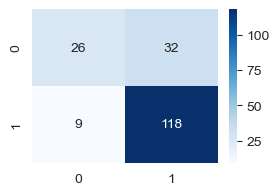

In [676]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(random_state = 123)
parameters = {
    'n_estimators' : [50, 100, 200],
    'criterion': ['entropy','gini'], 
    'max_depth': [2,5], # we try to avoid overfitting
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [2,5], # we try to avoid overfitting
    'class_weight' : [None]
}

model_rforest = GridS(classifier, parameters)

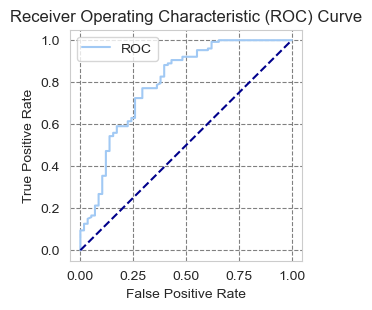

AUC: 0.79


In [677]:
fpr_rforest, tpr_rforest, auc_rforest, thr_rforest =ROC_AUC(model_rforest,X_train,y_train,X_test,y_test)

pack_model("Random Forest", model_rforest, fpr_rforest, tpr_rforest, auc_rforest, thr_rforest)

### Decision Tree classifier - AdaBoost

Best model | f1_train:  0.910736579275905  using:  {'learning_rate': 1, 'n_estimators': 100}
f1        | train 1.000  | test 0.834
accuracy  | train 1.000  | test 0.757
precision | train 1.000  | test 0.785
recall    | train 1.000  | test 0.890
fpr       | train 0.000  | test 0.534

[[ 27  31]
 [ 14 113]]


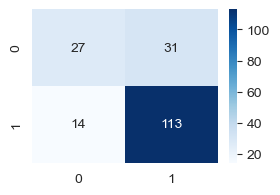

In [678]:

from sklearn.ensemble import AdaBoostClassifier

classifier = AdaBoostClassifier(random_state = 123)

parameters = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1]
}

model_adaboost = GridS(classifier, parameters)

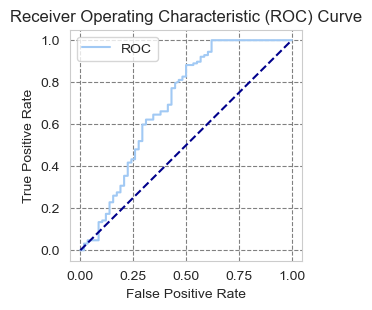

AUC: 0.70


In [679]:
fpr_adaboost, tpr_adaboost, auc_adaboost, thr_adaboost = ROC_AUC(model_adaboost, X_train, y_train, X_test, y_test)

pack_model("Tree - AdaBoost", model_adaboost, fpr_adaboost, tpr_adaboost, auc_adaboost, thr_adaboost)

### Decision Tree classifier - Bagging

Best model | f1_train:  0.9352728751135982  using:  {'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': 10, 'base_estimator__min_samples_leaf': 5, 'base_estimator__min_samples_split': 10, 'bootstrap': True, 'bootstrap_features': False, 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 50}
f1        | train 0.982  | test 0.853
accuracy  | train 0.983  | test 0.778
precision | train 0.965  | test 0.783
recall    | train 1.000  | test 0.937
fpr       | train 0.032  | test 0.569

[[ 25  33]
 [  8 119]]


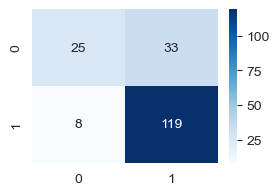

In [680]:
from sklearn.ensemble import BaggingClassifier

# features are selected to avoid overfitting

classifier = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state = 123))
parameters = {
    'base_estimator__criterion': ['entropy', 'gini'],
    'base_estimator__max_depth': [5, 10],  
    'base_estimator__min_samples_split': [10, 20],  
    'base_estimator__min_samples_leaf': [5, 10], 
    'n_estimators': [50, 100],  
    'max_samples': [0.6, 0.8],  
    'max_features': [0.6, 0.8],  
    'bootstrap': [True],  
    'bootstrap_features': [False]
}

model_bagging = GridS(classifier, parameters)


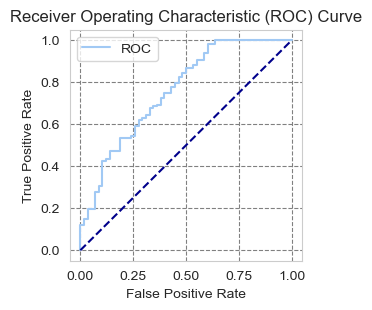

AUC: 0.76


In [681]:
fpr_bagging, tpr_bagging, auc_bagging, thr_bagging = ROC_AUC(model_bagging, X_train, y_train, X_test, y_test)

pack_model("Tree - Bagging", model_bagging, fpr_bagging, tpr_bagging, auc_bagging, thr_bagging)

### Naive Bayes classifier

f1        | train 0.888  | test 0.873
accuracy  | train 0.881  | test 0.800
precision | train 0.799  | test 0.774
recall    | train 1.000  | test 1.000
fpr       | train 0.224  | test 0.638

[[ 21  37]
 [  0 127]]


<AxesSubplot:>

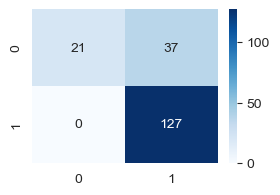

In [682]:
from sklearn.naive_bayes import GaussianNB 

model_GNB = GaussianNB()

model_GNB.fit(X_train, y_train)
y_pred=model_GNB.predict(X_test)
y_pred_train = model_GNB.predict(X_train)

# Training FPR
tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_pred_train).ravel()
fpr_train = fp_train / (fp_train + tn_train)

# Test FPR
tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred).ravel()
fpr_test = fp_test / (fp_test + tn_test)

print("f1        | train %.3f  | test %.3f" % (f1_score(y_train, y_pred_train), f1_score(y_test, y_pred) )) 
print("accuracy  | train %.3f  | test %.3f" % (accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred) )) 
print("precision | train %.3f  | test %.3f" % (precision_score(y_train, y_pred_train), precision_score(y_test, y_pred) )) 
print("recall    | train %.3f  | test %.3f" % (recall_score(y_train, y_pred_train), recall_score(y_test, y_pred) ))
print("fpr       | train %.3f  | test %.3f" % (fpr_train, fpr_test ))
con_mx = confusion_matrix(y_test, y_pred)
print("")
print(con_mx)
plt.figure(figsize=(3,2))
sns.heatmap(con_mx, annot=True, fmt='d', cmap="Blues")

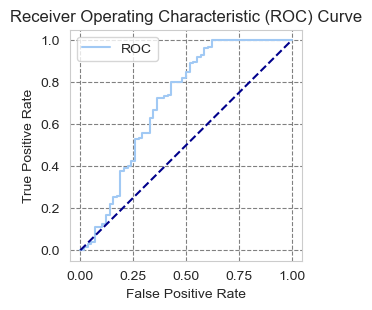

AUC: 0.71


In [683]:
fpr_GNB, tpr_GNB, auc_GNB, thr_GNB = ROC_AUC(model_GNB, X_train, y_train, X_test, y_test)

pack_model("GNB", model_GNB, fpr_GNB, tpr_GNB, auc_GNB, thr_GNB)

### Logistic Regression classifier

Best model | f1_train:  0.8659505907626208  using:  {'C': 10, 'max_iter': 100}
f1        | train 0.903  | test 0.861
accuracy  | train 0.905  | test 0.789
precision | train 0.872  | test 0.786
recall    | train 0.935  | test 0.953
fpr       | train 0.122  | test 0.569

[[ 25  33]
 [  6 121]]


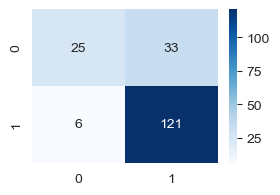

In [684]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state = 123)
parameters = {
    "C":[1e-4,1e-3,1e-2,1e-1,1,10], 
    "max_iter":[100,200,500,1000]
}

model_LR = GridS(classifier, parameters)

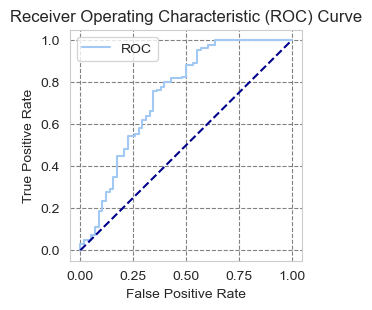

AUC: 0.74


In [685]:
fpr_LR, tpr_LR, auc_LR, thr_LR = ROC_AUC(model_LR, X_train, y_train, X_test, y_test)

pack_model("LR", model_LR, fpr_LR, tpr_LR, auc_LR, thr_LR)

### SVM classifier

Best model | f1_train:  0.9689805860018627  using:  {'C': 10, 'degree': 4, 'kernel': 'poly', 'probability': True}
f1        | train 0.993  | test 0.836
accuracy  | train 0.993  | test 0.773
precision | train 0.986  | test 0.829
recall    | train 1.000  | test 0.843
fpr       | train 0.013  | test 0.379

[[ 36  22]
 [ 20 107]]


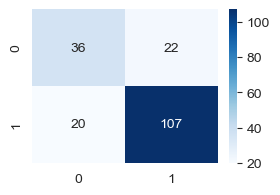

In [686]:
from sklearn.svm import SVC

classifier = SVC(random_state = 123)
parameters = {
    "kernel": ['linear', 'rbf', 'poly'],
    "C": [.01, .1, 1, 10],
    "degree": [2, 3, 4],
    "probability": [True]
}

model_SVM = GridS(classifier,parameters)

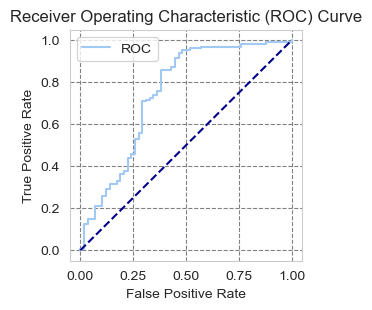

AUC: 0.75


In [687]:
fpr_SVM, tpr_SVM, auc_SVM, thr_SVM = ROC_AUC(model_SVM, X_train, y_train, X_test, y_test)

pack_model("SVM", model_SVM, fpr_SVM, tpr_SVM, auc_SVM, thr_SVM)

### ML Perceptron classifier

Best model | f1_train:  0.9483573121750708  using:  {'alpha': 0.0001, 'hidden_layer_sizes': (50, 20), 'max_iter': 1000}
f1        | train 0.986  | test 0.821
accuracy  | train 0.986  | test 0.746
precision | train 0.972  | test 0.794
recall    | train 1.000  | test 0.850
fpr       | train 0.026  | test 0.483

[[ 30  28]
 [ 19 108]]


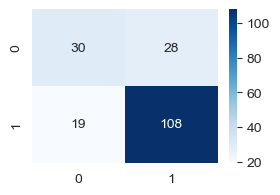

In [688]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier(random_state = 123)
parameters = {
    "hidden_layer_sizes":[(5,3,2),(10,5),(50,20),(5,3)],  
    "max_iter": [1000, 2000], 
    "alpha": [0.0001, 0.001,0.1,1]
}

model_MLP = GridS(classifier, parameters)

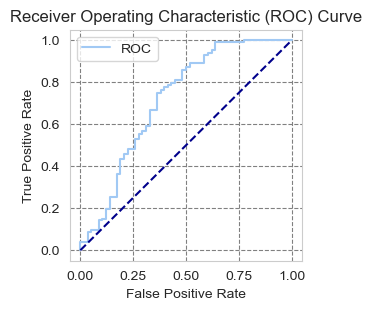

AUC: 0.72


In [689]:
fpr_MLP, tpr_MLP, auc_MLP, thr_MLP = ROC_AUC(model_MLP, X_train, y_train, X_test, y_test)

pack_model("MLP", model_MLP, fpr_MLP, tpr_MLP, auc_MLP, thr_MLP)

#### 6. **Final Analysis and Model Selection:** 
We identify the best-performing model (in this case....), summarize your findings, and save the selected model.

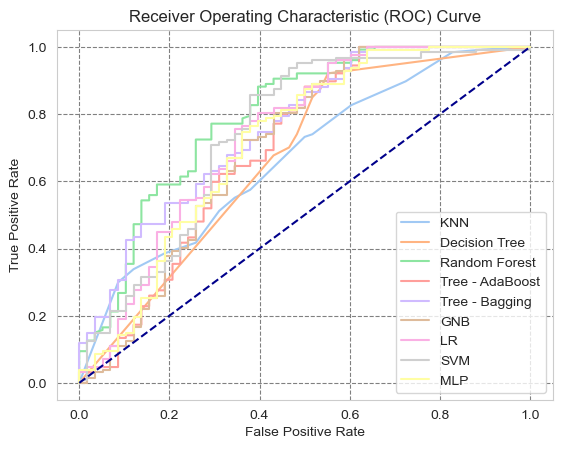

In [690]:
#showing all the ROCs on one graph

for model_key in models:
    plt.plot(models[model_key]["fpr"], models[model_key]["tpr"], label= model_key)

plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [691]:
auc_list = [auc_knn, auc_dtree, auc_rforest, auc_bagging, auc_adaboost, auc_GNB, auc_LR, auc_SVM, auc_MLP]
auc_name = ["knn", "Tree", "Random Forest", "Bagging", "Adaboost", "GNB", "LR", "SVM", "MLP"]
auc_dict = dict(zip(auc_name, auc_list)) # converting lists into a dictionary

print('AUC values:')
print('\n'.join(f"{key}: {value}" for key, value in auc_dict.items())) # printing all the AUC values
print(f"\nMaximal AUC value for {max(auc_dict, key=auc_dict.get)}: {auc_dict[max(auc_dict, key=auc_dict.get)]}") # getting max AUC value


AUC values:
knn: 0.6700380124898181
Tree: 0.6705131686125442
Random Forest: 0.7947325549823514
Bagging: 0.7587564485473799
Adaboost: 0.7000407276676622
GNB: 0.7064892750475156
LR: 0.7385283736084713
SVM: 0.7468096660331252
MLP: 0.7185718164539777

Maximal AUC value for Random Forest: 0.7947325549823514


#### Cost analysis for thrashhold identification

Evaluating the prediction we should consider:

- False Positives (FP): Approving loans that borrowers cannot repay can result in financial loss for the institution. This scenario should be minimized.
- False Negatives (FN): Rejecting loans for eligible borrowers can lead to loss of potential customers and business reputation issues.

We can fine-tune models threshold based on the trade-off between opportunity cost and financial risk.

To do that we have to assign costs to FP (approving a bad loan) and FN (rejecting a good loan).

The **cost of an FP** can be simplified to the loss of the loan amount. For simplification, we can approximate it as:

$$
FP\ \text{cost} = \text{mean value of the loan amount}
$$

In [692]:
FP_cost = data['LoanAmount'].mean()

FP_cost

146.41216216216216

The **cost of an FN** can be simplified to the loss of interest on loan. For simplification, we can approximate it as:
$$
FN\ \text{cost} = \text{mean value of the loan amount} \times \text{mean value of the loan term} \times \text{mean value of interest rate}
$$

We do not have values for the interest rate, so we have to take the average value from the internet.
According to [Investopedia](https://www.investopedia.com/what-is-the-average-personal-loan-interest-rate-8558877) the average personal loan interest rate in the US in 2024 is `26.11%`.

In [693]:
int_r = 0.2611

#we assume the loan term is given in months
FN_cost = data['LoanAmount'].mean() * data['Loan_Amount_Term'].mean()/365 * int_r

FN_cost

35.819314287301

Now, we can evaluate each model to determine its minimum cost, identify the corresponding threshold value, and calculate the associated performance metrics.

Total cost is calculated as:
$$
\text{Total Cost} = (\text{Cost of FP} \times \text{Number of FP}) + (\text{Cost of FN} \times \text{Number of FN})
$$

In [694]:
def cost_optimal(model_dict):
    
    costs = [(FP_cost * fp + FN_cost * (1 - tp)) for fp, tp in zip(model_dict["fpr"], model_dict["tpr"])]
    
    optimal_idx = costs.index(min(costs))
    thr_opt= model_dict["thr"][optimal_idx] # optimal threshold
    print("Minimal cost %.3f with threshold %.3f" % (costs[optimal_idx], thr_opt))
    
    y_prob = model_knn.predict_proba(X_test)
    y_pred = (y_prob[:, 1] >= thr_opt).astype(int) 

    y_prob_train = model_knn.predict_proba(X_train)
    y_pred_train = (y_prob_train[:, 1] >= thr_opt).astype(int) 

    print(confusion_matrix(y_test, y_pred))
    
    
    return(costs[optimal_idx], thr_opt)

In [695]:
for model_key in models:
    print(model_key)
    _,_ = cost_optimal(models[model_key])
    print('\n')

KNN
Minimal cost 35.819 with threshold 2.000
[[ 58   0]
 [127   0]]


Decision Tree
Minimal cost 35.819 with threshold 2.000
[[ 58   0]
 [127   0]]


Random Forest
Minimal cost 32.435 with threshold 0.879
[[51  7]
 [84 43]]


Tree - AdaBoost
Minimal cost 35.819 with threshold 1.612
[[ 58   0]
 [127   0]]


Tree - Bagging
Minimal cost 31.589 with threshold 0.957
[[53  5]
 [89 38]]


GNB
Minimal cost 35.819 with threshold 2.000
[[ 58   0]
 [127   0]]


LR
Minimal cost 34.691 with threshold 0.986
[[53  5]
 [89 38]]


SVM
Minimal cost 33.831 with threshold 1.000
[[53  5]
 [89 38]]


MLP
Minimal cost 34.409 with threshold 1.000
[[53  5]
 [89 38]]




Given the cost assumptions, all models exhibit a very high recall value. This method lacks practical utility.

**Overall**, the Random Forest model demonstrates the highest AUC among all the models. Additionally, it achieves the lowest cost based on the assumptions made. Actual data on costs is required.

We have selected this model for future predictions.

In [696]:
# saving the future usage

import pickle
pickle.dump(scaler, open('scaler.pkl', 'wb'))
pickle.dump(model_rforest, open('model.pkl', 'wb'))